In [ ]:
!pip install torch-dreams --upgrade

In [3]:
from torch_dreams.simple import vgg19_dreamer
import torch_dreams.utils as utils
import cv2 ## for saving images
import matplotlib.pyplot as plt
from torchvision import models
import numpy as np
from torchvision import transforms
import torch_dreams.dreamer as dreamer

plt.rcParams['figure.figsize'] = 10, 10


In [3]:
!wget https://i.pinimg.com/originals/af/7d/ef/af7def63c44526cecf13defd27530fd2.jpg

--2020-09-02 03:47:37--  https://i.pinimg.com/originals/af/7d/ef/af7def63c44526cecf13defd27530fd2.jpg
Resolving i.pinimg.com (i.pinimg.com)... 151.101.36.84, 2a04:4e42:9::84
Connecting to i.pinimg.com (i.pinimg.com)|151.101.36.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 367779 (359K) [image/jpeg]
Saving to: ‘af7def63c44526cecf13defd27530fd2.jpg’

af7def63c44526cecf1 100%[===================>] 359.16K  --.-KB/s    in 0.02s   

2020-09-02 03:47:37 (15.8 MB/s) - ‘af7def63c44526cecf13defd27530fd2.jpg’ saved [367779/367779]



In [14]:
from torch_dreams.simple import vgg19_dreamer
import cv2 ## for saving images

simple_dreamer = vgg19_dreamer()

dreamed_image = simple_dreamer.dream(
    image_path = "af7def63c44526cecf13defd27530fd2.jpg",
    layer_index= 17,
    iterations= 3,
    num_octaves = 7
    size = (256,256)
)

100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


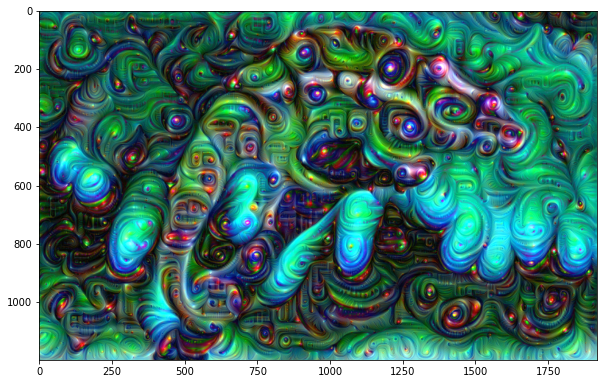

In [15]:
plt.imshow(dreamed_image)

In [4]:
!pip install pytube3 --upgrade
from pytube import YouTube

Requirement already up-to-date: pytube3 in /usr/local/lib/python3.6/dist-packages (9.6.4)


In [5]:
url = "https://www.youtube.com/watch?v=gPmKG20bElQ"

yt = YouTube(url)

yt.streams.all()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated function all (This object can be treated as a list, all() is useless).
  """


[<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.4d401f" progressive="False" type="video">,
 <Stream: itag="247" mime_type="video/webm" res="720p" fps="30fps" vcodec="vp9" progressive="False" type="video">,
 <Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d4014" progressive="False" type="video">,
 <Stream: itag="244" mime_type="video/webm" res="480p" fps="30fps" vcodec="vp9" progressive="False" type="video">,
 <Stream: itag="134" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.4d401e" progressive="False" type="video">,
 <Stream: itag="243" mime_type="video/webm" res="360p" fps="30fps" vcodec="vp9" progressive="False" type="video">,
 <Stream: i

In [6]:
video_name = yt.streams.get_by_itag('134').download()

In [8]:
from torch_dreams.simple import vgg19_dreamer

simple_dreamer = vgg19_dreamer()

In [ ]:
simple_dreamer.deep_dream_on_video(
    video_path = video_name,
    save_name = "deep_dream_island.mp4",
    layer = simple_dreamer.layers[13],
    octave_scale= 1.3,
    num_octaves = 3,
    iterations=3,
    lr = 0.09,
    framerate= 30.0,
    skip_value =  1,
)

In [10]:
!cp deep_dream_island.mp4 /content/drive/"My Drive"/torch_dreams/